In [1]:
import numpy as np
import struct
import time
import json
from pathlib import Path
from typing import Tuple, Dict, List
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')

PyTorch version: 2.9.1+cu128
CUDA available: False


In [2]:
# Paths
base_dir = Path('/data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators')
models_dir = base_dir / 'ml_models' / 'models'
plots_dir = base_dir / 'plots'
plots_dir.mkdir(exist_ok=True)

## 1. Define Magnetic Field and Integrators

In [3]:
class LHCbMagneticField:
    """Simplified LHCb dipole magnetic field model."""
    def __init__(self, polarity=1):
        self.polarity = polarity
        self.B0 = 1.0  # Tesla
        self.z_center = 5250.0  # mm
        self.z_halfwidth = 2500.0  # mm
        
    def get_field(self, x, y, z):
        z_rel = (z - self.z_center) / self.z_halfwidth
        By_profile = np.exp(-0.5 * z_rel**2)
        r_trans = np.sqrt(x**2 + y**2)
        fringe_factor = 1.0 - 0.0001 * (r_trans / 1000.0)**2
        By = self.polarity * self.B0 * By_profile * fringe_factor
        Bx = -0.01 * By * (x / 1000.0)
        return (Bx, By, 0.0)

class LHCbMagneticFieldTorch(nn.Module):
    """Differentiable field for PINN."""
    def __init__(self, polarity=1):
        super().__init__()
        self.polarity = polarity
        self.B0 = 1.0
        self.z_center = 5250.0
        self.z_halfwidth = 2500.0
        
    def forward(self, x, y, z):
        z_rel = (z - self.z_center) / self.z_halfwidth
        By_profile = torch.exp(-0.5 * z_rel**2)
        r_trans = torch.sqrt(x**2 + y**2)
        fringe_factor = 1.0 - 0.0001 * (r_trans / 1000.0)**2
        By = self.polarity * self.B0 * By_profile * fringe_factor
        Bx = -0.01 * By * (x / 1000.0)
        return Bx, By, torch.zeros_like(x)

In [4]:
class RKIntegrator:
    """Runge-Kutta integrator with configurable step size."""
    def __init__(self, field, step_size=10.0, use_rk8=False):
        self.field = field
        self.step_size = step_size
        self.c_light = 299.792458  # mm/ns
        self.use_rk8 = use_rk8
        
    def derivatives(self, z, state):
        x, y, tx, ty, qop = state
        Bx, By, Bz = self.field.get_field(x, y, z)
        factor = qop * self.c_light * 1e-3
        norm = np.sqrt(1.0 + tx**2 + ty**2)
        dtx_dz = factor * norm * (tx * ty * Bx - (1 + tx**2) * By + ty * Bz)
        dty_dz = factor * norm * ((1 + ty**2) * Bx - tx * ty * By - tx * Bz)
        return np.array([tx, ty, dtx_dz, dty_dz, 0.0])
    
    def rk4_step(self, z, state, h):
        k1 = self.derivatives(z, state)
        k2 = self.derivatives(z + 0.5*h, state + 0.5*h*k1)
        k3 = self.derivatives(z + 0.5*h, state + 0.5*h*k2)
        k4 = self.derivatives(z + h, state + h*k3)
        return state + (h/6.0) * (k1 + 2*k2 + 2*k3 + k4)
    
    def rk8_step(self, z, state, h):
        """RK8 via Richardson extrapolation."""
        state_half = self.rk4_step(z, state, h/2)
        state_two_half = self.rk4_step(z + h/2, state_half, h/2)
        state_full = self.rk4_step(z, state, h)
        return (16.0 * state_two_half - state_full) / 15.0
    
    def propagate(self, state_in, z_in, z_out):
        state = state_in.copy()
        dz = z_out - z_in
        n_steps = max(1, int(np.ceil(abs(dz) / self.step_size)))
        h = dz / n_steps
        z = z_in
        
        step_fn = self.rk8_step if self.use_rk8 else self.rk4_step
        for _ in range(n_steps):
            state = step_fn(z, state, h)
            z += h
        return state
    
    def propagate_trajectory(self, state_in, z_in, z_out, n_points=50):
        z_vals = np.linspace(z_in, z_out, n_points)
        states = np.zeros((n_points, 5))
        states[0] = state_in
        for i in range(1, n_points):
            states[i] = self.propagate(states[i-1], z_vals[i-1], z_vals[i])
        return z_vals, states

## 2. Generate Full Domain Training Data

In [10]:
def generate_data(n_samples, seed=42):
    """Generate training data with full momentum coverage."""
    np.random.seed(seed)
    
    field = LHCbMagneticField(polarity=1)
    integrator = RKIntegrator(field, step_size=5.0, use_rk8=True)  # High precision
    
    z_in, z_out = 3000.0, 7000.0
    dz = z_out - z_in
    
    X_list, Y_list = [], []
    
    for i in range(n_samples):
        if (i + 1) % 2000 == 0:
            print(f'  Generated {i+1}/{n_samples}')
        
        # Random initial state
        x0 = np.random.uniform(-900, 900)
        y0 = np.random.uniform(-750, 750)
        tx0 = np.random.uniform(-0.3, 0.3)
        ty0 = np.random.uniform(-0.25, 0.25)
        
        # Log-uniform momentum: 1-100 GeV
        p_gev = np.exp(np.random.uniform(np.log(1.0), np.log(100)))
        
        charge = np.random.choice([-1, 1])
        qop = charge / (p_gev * 1000.0)
        
        state_in = np.array([x0, y0, tx0, ty0, qop])
        state_out = integrator.propagate(state_in, z_in, z_out)
        
        # Filter bad propagations
        if np.all(np.isfinite(state_out)) and np.abs(state_out[2]) < 5:
            X_list.append([x0, y0, tx0, ty0, qop, dz])
            Y_list.append(state_out[:4])
    
    return np.array(X_list), np.array(Y_list)

print('Generating training data (20000 samples)...')
X_train, Y_train = generate_data(20000, seed=42)
print(f'Training samples: {len(X_train)}')

print('\nGenerating test data (2000 samples)...')
X_test, Y_test = generate_data(2000, seed=123)
print(f'Test samples: {len(X_test)}')

# Print stats
momenta = np.abs(1.0 / X_train[:, 4]) / 1000
print(f'\nMomentum range: {momenta.min():.1f} - {momenta.max():.1f} GeV/c')

Generating training data (20000 samples)...
  Generated 2000/20000
  Generated 4000/20000
  Generated 6000/20000
  Generated 8000/20000
  Generated 10000/20000
  Generated 12000/20000
  Generated 14000/20000
  Generated 16000/20000
  Generated 18000/20000
  Generated 20000/20000
Training samples: 19344

Generating test data (2000 samples)...
  Generated 2000/2000
Test samples: 1945

Momentum range: 1.0 - 100.0 GeV/c


## 3. Define Neural Network Models

In [5]:
class TrackMLP(nn.Module):
    """Data-driven MLP."""
    def __init__(self, hidden_dims=[256, 256, 128, 64]):
        super().__init__()
        layers = []
        prev_dim = 6
        for dim in hidden_dims:
            layers.extend([nn.Linear(prev_dim, dim), nn.Tanh()])
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, 4))
        self.network = nn.Sequential(*layers)
        
        self.register_buffer('input_mean', torch.zeros(6))
        self.register_buffer('input_std', torch.ones(6))
        self.register_buffer('output_mean', torch.zeros(4))
        self.register_buffer('output_std', torch.ones(4))
        
    def forward(self, x):
        x = (x - self.input_mean) / self.input_std
        out = self.network(x)
        return out * self.output_std + self.output_mean
    
    def save_binary(self, filepath):
        with open(filepath, 'wb') as f:
            linear_layers = [m for m in self.network if isinstance(m, nn.Linear)]
            f.write(struct.pack('i', len(linear_layers)))
            for layer in linear_layers:
                W = layer.weight.detach().cpu().numpy()
                b = layer.bias.detach().cpu().numpy()
                f.write(struct.pack('ii', *W.shape))
                f.write(W.astype(np.float64).tobytes())
                f.write(b.astype(np.float64).tobytes())
            for arr in [self.input_mean, self.input_std]:
                a = arr.cpu().numpy()
                f.write(struct.pack('i', len(a)))
                f.write(a.astype(np.float64).tobytes())
            for arr in [self.output_mean, self.output_std]:
                a = arr.cpu().numpy()
                f.write(struct.pack('i', len(a)))
                f.write(a.astype(np.float64).tobytes())

class TrackPINN(nn.Module):
    """Physics-Informed Neural Network."""
    def __init__(self, hidden_dims=[256, 256, 128, 64]):
        super().__init__()
        layers = []
        prev_dim = 6
        for dim in hidden_dims:
            layers.extend([nn.Linear(prev_dim, dim), nn.Tanh()])
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, 4))
        self.network = nn.Sequential(*layers)
        
        self.register_buffer('input_mean', torch.zeros(6))
        self.register_buffer('input_std', torch.ones(6))
        self.register_buffer('output_mean', torch.zeros(4))
        self.register_buffer('output_std', torch.ones(4))
        
        # Xavier init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = (x - self.input_mean) / self.input_std
        out = self.network(x)
        return out * self.output_std + self.output_mean
    
    def forward_with_grad(self, x):
        x = x.clone().requires_grad_(True)
        output = self.forward(x)
        dout_dz = torch.zeros_like(output)
        for i in range(4):
            grad = torch.autograd.grad(output[:, i].sum(), x, create_graph=True, retain_graph=True)[0]
            dout_dz[:, i] = grad[:, 5]
        return output, dout_dz
    
    def save_binary(self, filepath):
        with open(filepath, 'wb') as f:
            linear_layers = [m for m in self.network if isinstance(m, nn.Linear)]
            f.write(struct.pack('i', len(linear_layers)))
            for layer in linear_layers:
                W = layer.weight.detach().cpu().numpy()
                b = layer.bias.detach().cpu().numpy()
                f.write(struct.pack('ii', *W.shape))
                f.write(W.astype(np.float64).tobytes())
                f.write(b.astype(np.float64).tobytes())
            for arr in [self.input_mean, self.input_std]:
                a = arr.cpu().numpy()
                f.write(struct.pack('i', len(a)))
                f.write(a.astype(np.float64).tobytes())
            for arr in [self.output_mean, self.output_std]:
                a = arr.cpu().numpy()
                f.write(struct.pack('i', len(a)))
                f.write(a.astype(np.float64).tobytes())

## 4. Train MLP Model

In [12]:
def train_mlp(X, Y, epochs=1000, lr=1e-3, batch_size=256):
    """Train data-driven MLP."""
    n_train = int(0.85 * len(X))
    X_t = torch.FloatTensor(X[:n_train])
    Y_t = torch.FloatTensor(Y[:n_train])
    X_val = torch.FloatTensor(X[n_train:])
    Y_val = torch.FloatTensor(Y[n_train:])
    
    model = TrackMLP()
    model.input_mean = X_t.mean(dim=0)
    model.input_std = X_t.std(dim=0) + 1e-8
    model.output_mean = Y_t.mean(dim=0)
    model.output_std = Y_t.std(dim=0) + 1e-8
    
    loader = DataLoader(TensorDataset(X_t, Y_t), batch_size=batch_size, shuffle=True)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.MSELoss()
    
    history = {'train': [], 'val': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for bx, by in loader:
            optimizer.zero_grad()
            loss = criterion(model(bx), by)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(loader)
        scheduler.step()
        
        model.eval()
        with torch.no_grad():
            val_loss = criterion(model(X_val), Y_val).item()
        
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1:4d}: Train={train_loss:.6f}, Val={val_loss:.6f}')
    
    return model, history

print('Training MLP...')
mlp_model, mlp_history = train_mlp(X_train, Y_train, epochs=1000)

Training MLP...
Epoch  100: Train=269.877831, Val=96.865204
Epoch  200: Train=49.694555, Val=54.665844
Epoch  300: Train=46.506339, Val=30.336008
Epoch  400: Train=35.728185, Val=58.927738
Epoch  500: Train=8.890604, Val=16.746782
Epoch  600: Train=5.929850, Val=18.438215
Epoch  700: Train=3.245967, Val=10.579026
Epoch  800: Train=0.920813, Val=7.981174
Epoch  900: Train=0.342773, Val=6.310643
Epoch 1000: Train=0.236910, Val=6.398001


## 5. Train PINN Model

In [13]:
def train_pinn(X, Y, epochs=1000, lr=1e-3, lambda_phys=0.1, batch_size=256):
    """Train physics-informed neural network."""
    z_start, z_end = 3000.0, 7000.0
    c_light = 299.792458
    field = LHCbMagneticFieldTorch()
    
    n_train = int(0.85 * len(X))
    
    # Boundary data: at z_start (initial) and z_end (final)
    X_start = np.hstack([X[:n_train, :5], np.full((n_train, 1), z_start)])
    X_end = np.hstack([X[:n_train, :5], np.full((n_train, 1), z_end)])
    Y_start = X[:n_train, :4]  # Initial state
    Y_end = Y[:n_train]  # Final state
    
    X_start_t = torch.FloatTensor(X_start)
    Y_start_t = torch.FloatTensor(Y_start)
    X_end_t = torch.FloatTensor(X_end)
    Y_end_t = torch.FloatTensor(Y_end)
    
    model = TrackPINN()
    X_all = torch.cat([X_start_t, X_end_t])
    Y_all = torch.cat([Y_start_t, Y_end_t])
    model.input_mean = X_all.mean(dim=0)
    model.input_std = X_all.std(dim=0) + 1e-8
    model.output_mean = Y_all.mean(dim=0)
    model.output_std = Y_all.std(dim=0) + 1e-8
    
    loader_s = DataLoader(TensorDataset(X_start_t, Y_start_t), batch_size=batch_size, shuffle=True)
    loader_e = DataLoader(TensorDataset(X_end_t, Y_end_t), batch_size=batch_size, shuffle=True)
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    mse = nn.MSELoss()
    
    history = {'total': [], 'data': [], 'physics': []}
    
    for epoch in range(epochs):
        model.train()
        total, data_l, phys_l = 0, 0, 0
        n_batch = 0
        
        for (xs, ys), (xe, ye) in zip(loader_s, loader_e):
            optimizer.zero_grad()
            
            # Boundary losses
            loss_start = mse(model(xs), ys)
            loss_end = mse(model(xe), ye)
            loss_data = loss_start + loss_end
            
            # Physics loss at collocation points
            n_coll = min(32, len(xs))
            z_coll = torch.rand(n_coll) * (z_end - z_start) + z_start
            idx = torch.randint(0, len(xs), (n_coll,))
            x_coll = torch.zeros(n_coll, 6)
            x_coll[:, :5] = xs[idx, :5]
            x_coll[:, 5] = z_coll
            
            state, dstate = model.forward_with_grad(x_coll)
            x, y, tx, ty = state[:, 0], state[:, 1], state[:, 2], state[:, 3]
            dx, dy, dtx, dty = dstate[:, 0], dstate[:, 1], dstate[:, 2], dstate[:, 3]
            qop = x_coll[:, 4]
            z = x_coll[:, 5]
            
            Bx, By, Bz = field(x, y, z)
            kappa = c_light * 1e-3 * qop
            norm = torch.sqrt(1 + tx**2 + ty**2)
            
            res = (dx - tx)**2 + (dy - ty)**2
            res += (dtx - kappa * norm * (tx*ty*Bx - (1+tx**2)*By + ty*Bz))**2
            res += (dty - kappa * norm * ((1+ty**2)*Bx - tx*ty*By - tx*Bz))**2
            loss_physics = torch.mean(res)
            
            loss = loss_data + lambda_phys * loss_physics
            loss.backward()
            optimizer.step()
            
            total += loss.item()
            data_l += loss_data.item()
            phys_l += loss_physics.item()
            n_batch += 1
        
        scheduler.step()
        history['total'].append(total/n_batch)
        history['data'].append(data_l/n_batch)
        history['physics'].append(phys_l/n_batch)
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1:4d}: Total={total/n_batch:.6f}, Data={data_l/n_batch:.6f}, Physics={phys_l/n_batch:.6f}')
    
    return model, history

print('Training PINN...')
pinn_model, pinn_history = train_pinn(X_train, Y_train, epochs=1000, lambda_phys=0.1)

Training PINN...
Epoch  100: Total=227.483753, Data=227.218002, Physics=2.657507
Epoch  200: Total=224.877426, Data=224.633753, Physics=2.436723
Epoch  300: Total=74.405127, Data=74.248353, Physics=1.567734
Epoch  400: Total=14.188270, Data=14.035335, Physics=1.529349
Epoch  500: Total=18.993717, Data=18.868400, Physics=1.253166
Epoch  600: Total=7.360389, Data=7.244686, Physics=1.157029
Epoch  700: Total=15.609673, Data=15.507052, Physics=1.026209
Epoch  800: Total=1.968253, Data=1.873202, Physics=0.950507
Epoch  900: Total=1.007358, Data=0.922128, Physics=0.852299
Epoch 1000: Total=0.726740, Data=0.641425, Physics=0.853147


In [14]:
# Save models
mlp_model.save_binary(str(models_dir / 'mlp_full_domain.bin'))
pinn_model.save_binary(str(models_dir / 'pinn_full_domain.bin'))
print('Models saved!')

Models saved!


In [6]:
# Load saved models and regenerate test data for benchmarking
def load_model_binary(filepath, model_class):
    """Load a model from binary file."""
    model = model_class()
    with open(filepath, 'rb') as f:
        n_layers = struct.unpack('i', f.read(4))[0]
        linear_layers = [m for m in model.network if isinstance(m, nn.Linear)]
        for i, layer in enumerate(linear_layers):
            rows, cols = struct.unpack('ii', f.read(8))
            W = np.frombuffer(f.read(rows * cols * 8), dtype=np.float64).reshape(rows, cols)
            b = np.frombuffer(f.read(rows * 8), dtype=np.float64)
            layer.weight.data = torch.FloatTensor(W)
            layer.bias.data = torch.FloatTensor(b)
        
        for name in ['input_mean', 'input_std']:
            n = struct.unpack('i', f.read(4))[0]
            arr = np.frombuffer(f.read(n * 8), dtype=np.float64)
            setattr(model, name, torch.FloatTensor(arr))
        for name in ['output_mean', 'output_std']:
            n = struct.unpack('i', f.read(4))[0]
            arr = np.frombuffer(f.read(n * 8), dtype=np.float64)
            setattr(model, name, torch.FloatTensor(arr))
    return model

# Load models
print("Loading saved models...")
mlp_model = load_model_binary(str(models_dir / 'mlp_full_domain.bin'), TrackMLP)
pinn_model = load_model_binary(str(models_dir / 'pinn_full_domain.bin'), TrackPINN)
print("Models loaded!")

# Regenerate test data (smaller set for quick benchmarking)
print("\nGenerating test data...")
def generate_test_data(n_samples, seed=123):
    np.random.seed(seed)
    field = LHCbMagneticField(polarity=1)
    integrator = RKIntegrator(field, step_size=5.0, use_rk8=True)
    z_in, z_out = 3000.0, 7000.0
    dz = z_out - z_in
    X_list, Y_list = [], []
    for i in range(n_samples):
        x0 = np.random.uniform(-900, 900)
        y0 = np.random.uniform(-750, 750)
        tx0 = np.random.uniform(-0.3, 0.3)
        ty0 = np.random.uniform(-0.25, 0.25)
        p_gev = np.exp(np.random.uniform(np.log(1.0), np.log(100)))
        charge = np.random.choice([-1, 1])
        qop = charge / (p_gev * 1000.0)
        state_in = np.array([x0, y0, tx0, ty0, qop])
        state_out = integrator.propagate(state_in, z_in, z_out)
        if np.all(np.isfinite(state_out)) and np.abs(state_out[2]) < 5:
            X_list.append([x0, y0, tx0, ty0, qop, dz])
            Y_list.append(state_out[:4])
    return np.array(X_list), np.array(Y_list)

X_test, Y_test = generate_test_data(2000)
print(f"Test samples: {len(X_test)}")

Loading saved models...
Models loaded!

Generating test data...
Test samples: 1945


## 6. Benchmark All Methods

In [8]:
def benchmark(X, Y_truth, mlp, pinn):
    """Benchmark all methods against RK8 truth."""
    field = LHCbMagneticField()
    z_in, z_out = 3000.0, 7000.0
    n = len(X)
    
    methods = {
        'RK8 (5mm)': RKIntegrator(field, step_size=5.0, use_rk8=True),
        'RK4 (10mm)': RKIntegrator(field, step_size=10.0, use_rk8=False),
        'RK4 (50mm)': RKIntegrator(field, step_size=50.0, use_rk8=False),
        'RK4 (100mm)': RKIntegrator(field, step_size=100.0, use_rk8=False),
    }
    
    results = {}
    
    # Benchmark RK methods
    for name, integ in methods.items():
        print(f'Benchmarking {name}...')
        preds = np.zeros((n, 4))
        start = time.time()
        for i in range(n):
            preds[i] = integ.propagate(X[i, :5], z_in, z_out)[:4]
        elapsed = time.time() - start
        
        errs = preds - Y_truth
        radial = np.sqrt(errs[:, 0]**2 + errs[:, 1]**2)
        results[name] = {
            'preds': preds, 'errors': errs, 'radial': radial,
            'mean': np.mean(radial), 'std': np.std(radial),
            'max': np.max(radial), 'p95': np.percentile(radial, 95),
            'time_us': (elapsed/n)*1e6
        }
        print(f'  Mean error: {results[name]["mean"]:.3f} mm, Time: {results[name]["time_us"]:.1f} μs')
    
    # MLP
    print('Benchmarking MLP...')
    mlp.eval()
    X_t = torch.FloatTensor(X)
    with torch.no_grad():
        start = time.time()
        for _ in range(10): pred_mlp = mlp(X_t)
        elapsed = (time.time() - start) / 10
    pred_mlp = pred_mlp.numpy()
    errs = pred_mlp - Y_truth
    radial = np.sqrt(errs[:, 0]**2 + errs[:, 1]**2)
    results['MLP'] = {
        'preds': pred_mlp, 'errors': errs, 'radial': radial,
        'mean': np.mean(radial), 'std': np.std(radial),
        'max': np.max(radial), 'p95': np.percentile(radial, 95),
        'time_us': (elapsed/n)*1e6
    }
    print(f'  Mean error: {results["MLP"]["mean"]:.3f} mm, Time: {results["MLP"]["time_us"]:.2f} μs')
    
    # PINN
    print('Benchmarking PINN...')
    pinn.eval()
    X_pinn = np.hstack([X[:, :5], np.full((n, 1), z_out)])
    X_pinn_t = torch.FloatTensor(X_pinn)
    with torch.no_grad():
        start = time.time()
        for _ in range(10): pred_pinn = pinn(X_pinn_t)
        elapsed = (time.time() - start) / 10
    pred_pinn = pred_pinn.numpy()
    errs = pred_pinn - Y_truth
    radial = np.sqrt(errs[:, 0]**2 + errs[:, 1]**2)
    results['PINN'] = {
        'preds': pred_pinn, 'errors': errs, 'radial': radial,
        'mean': np.mean(radial), 'std': np.std(radial),
        'max': np.max(radial), 'p95': np.percentile(radial, 95),
        'time_us': (elapsed/n)*1e6
    }
    print(f'  Mean error: {results["PINN"]["mean"]:.3f} mm, Time: {results["PINN"]["time_us"]:.2f} μs')
    
    return results

print('\n=== BENCHMARKING ===')
results = benchmark(X_test, Y_test, mlp_model, pinn_model)


=== BENCHMARKING ===
Benchmarking RK8 (5mm)...


  Mean error: 0.000 mm, Time: 174622.5 μs
Benchmarking RK4 (10mm)...
  Mean error: 0.000 mm, Time: 27718.2 μs
Benchmarking RK4 (50mm)...
  Mean error: 0.000 mm, Time: 5547.7 μs
Benchmarking RK4 (100mm)...
  Mean error: 0.001 mm, Time: 2798.5 μs
Benchmarking MLP...
  Mean error: 1.476 mm, Time: 5.81 μs
Benchmarking PINN...
  Mean error: 1.277 mm, Time: 1.47 μs


## 7. Visualizations

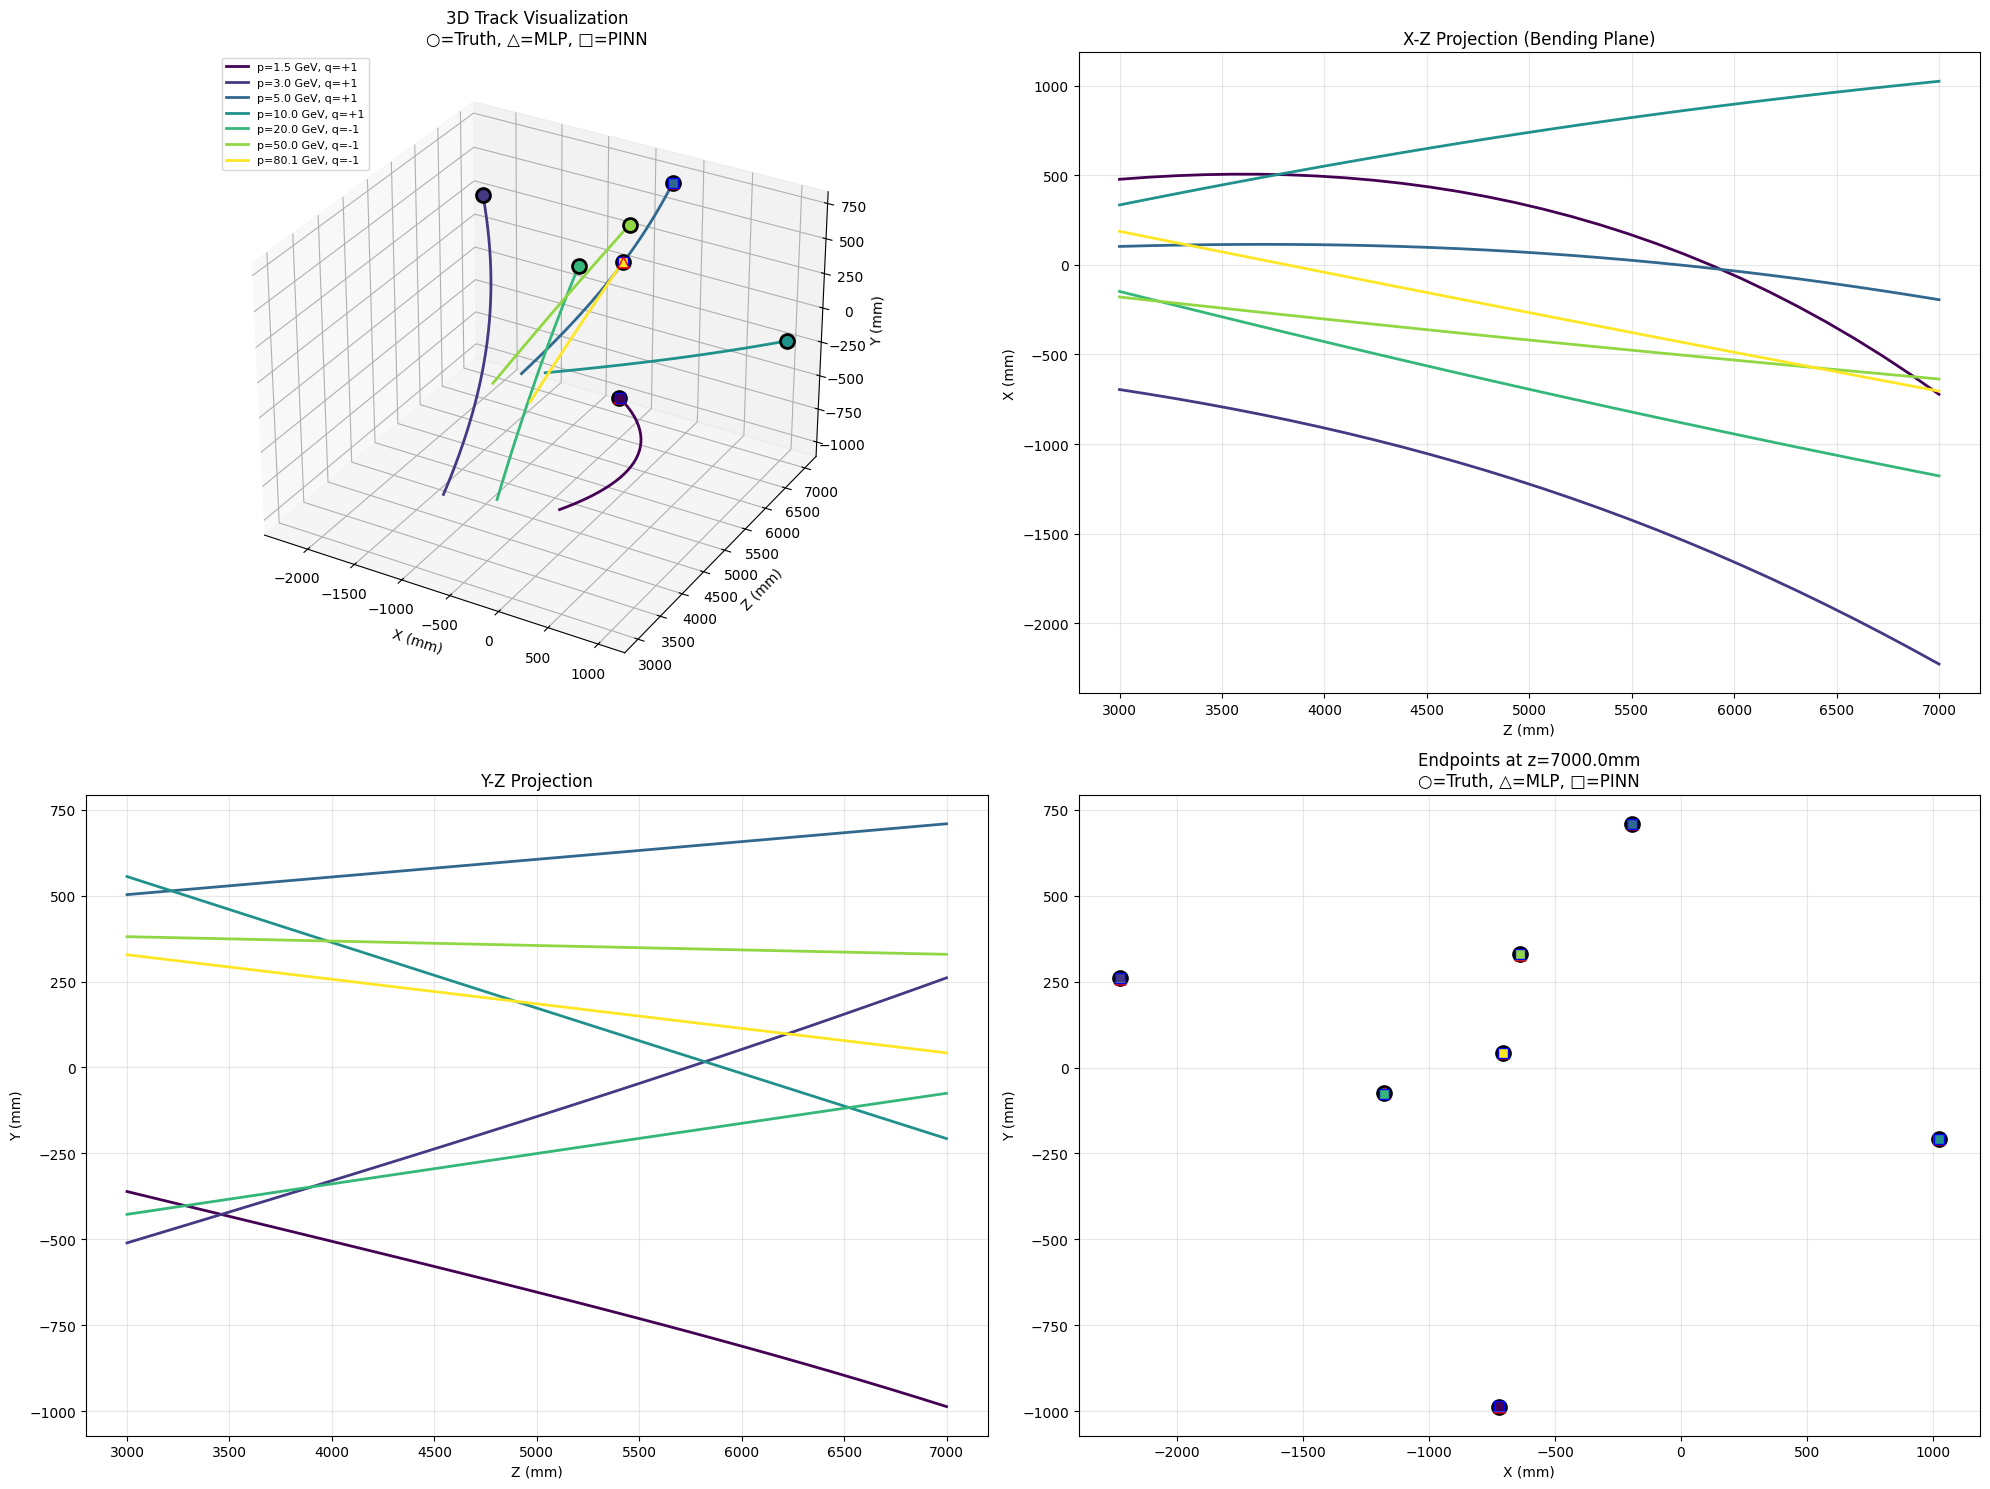

In [9]:
# 3D Track Visualization
fig = plt.figure(figsize=(20, 15))

field = LHCbMagneticField()
integrator = RKIntegrator(field, step_size=20.0, use_rk8=True)
z_in, z_out = 3000.0, 7000.0

# Select tracks at different momenta
momenta = np.abs(1.0 / X_test[:, 4]) / 1000
selected = []
for p_target in [1.5, 3, 5, 10, 20, 50, 80]:
    idx = np.argmin(np.abs(momenta - p_target))
    selected.append(idx)

colors = plt.cm.viridis(np.linspace(0, 1, len(selected)))

# 3D plot
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax2 = fig.add_subplot(2, 2, 2)  # X-Z
ax3 = fig.add_subplot(2, 2, 3)  # Y-Z
ax4 = fig.add_subplot(2, 2, 4)  # X-Y endpoint

for i, idx in enumerate(selected):
    state_in = X_test[idx, :5]
    p_gev = abs(1.0/state_in[4]) / 1000
    q = int(np.sign(state_in[4]))
    
    z_vals, states = integrator.propagate_trajectory(state_in, z_in, z_out, n_points=30)
    
    label = f'p={p_gev:.1f} GeV, q={q:+d}'
    ax1.plot(states[:, 0], z_vals, states[:, 1], '-', color=colors[i], lw=2, label=label)
    ax2.plot(z_vals, states[:, 0], '-', color=colors[i], lw=2)
    ax3.plot(z_vals, states[:, 1], '-', color=colors[i], lw=2)
    
    # Endpoints
    truth = Y_test[idx]
    mlp_pred = results['MLP']['preds'][idx]
    pinn_pred = results['PINN']['preds'][idx]
    
    ax1.scatter([truth[0]], [z_out], [truth[1]], marker='o', s=100, color=colors[i], edgecolor='k', lw=2)
    ax1.scatter([mlp_pred[0]], [z_out], [mlp_pred[1]], marker='^', s=60, color=colors[i], edgecolor='red', lw=1)
    ax1.scatter([pinn_pred[0]], [z_out], [pinn_pred[1]], marker='s', s=60, color=colors[i], edgecolor='blue', lw=1)
    
    ax4.scatter([truth[0]], [truth[1]], marker='o', s=100, color=colors[i], edgecolor='k', lw=2)
    ax4.scatter([mlp_pred[0]], [mlp_pred[1]], marker='^', s=60, color=colors[i], edgecolor='red', lw=1)
    ax4.scatter([pinn_pred[0]], [pinn_pred[1]], marker='s', s=60, color=colors[i], edgecolor='blue', lw=1)

ax1.set_xlabel('X (mm)')
ax1.set_ylabel('Z (mm)')
ax1.set_zlabel('Y (mm)')
ax1.set_title('3D Track Visualization\n○=Truth, △=MLP, □=PINN')
ax1.legend(fontsize=8, loc='upper left')

ax2.set_xlabel('Z (mm)')
ax2.set_ylabel('X (mm)')
ax2.set_title('X-Z Projection (Bending Plane)')
ax2.grid(True, alpha=0.3)

ax3.set_xlabel('Z (mm)')
ax3.set_ylabel('Y (mm)')
ax3.set_title('Y-Z Projection')
ax3.grid(True, alpha=0.3)

ax4.set_xlabel('X (mm)')
ax4.set_ylabel('Y (mm)')
ax4.set_title(f'Endpoints at z={z_out}mm\n○=Truth, △=MLP, □=PINN')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(plots_dir / '3d_track_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

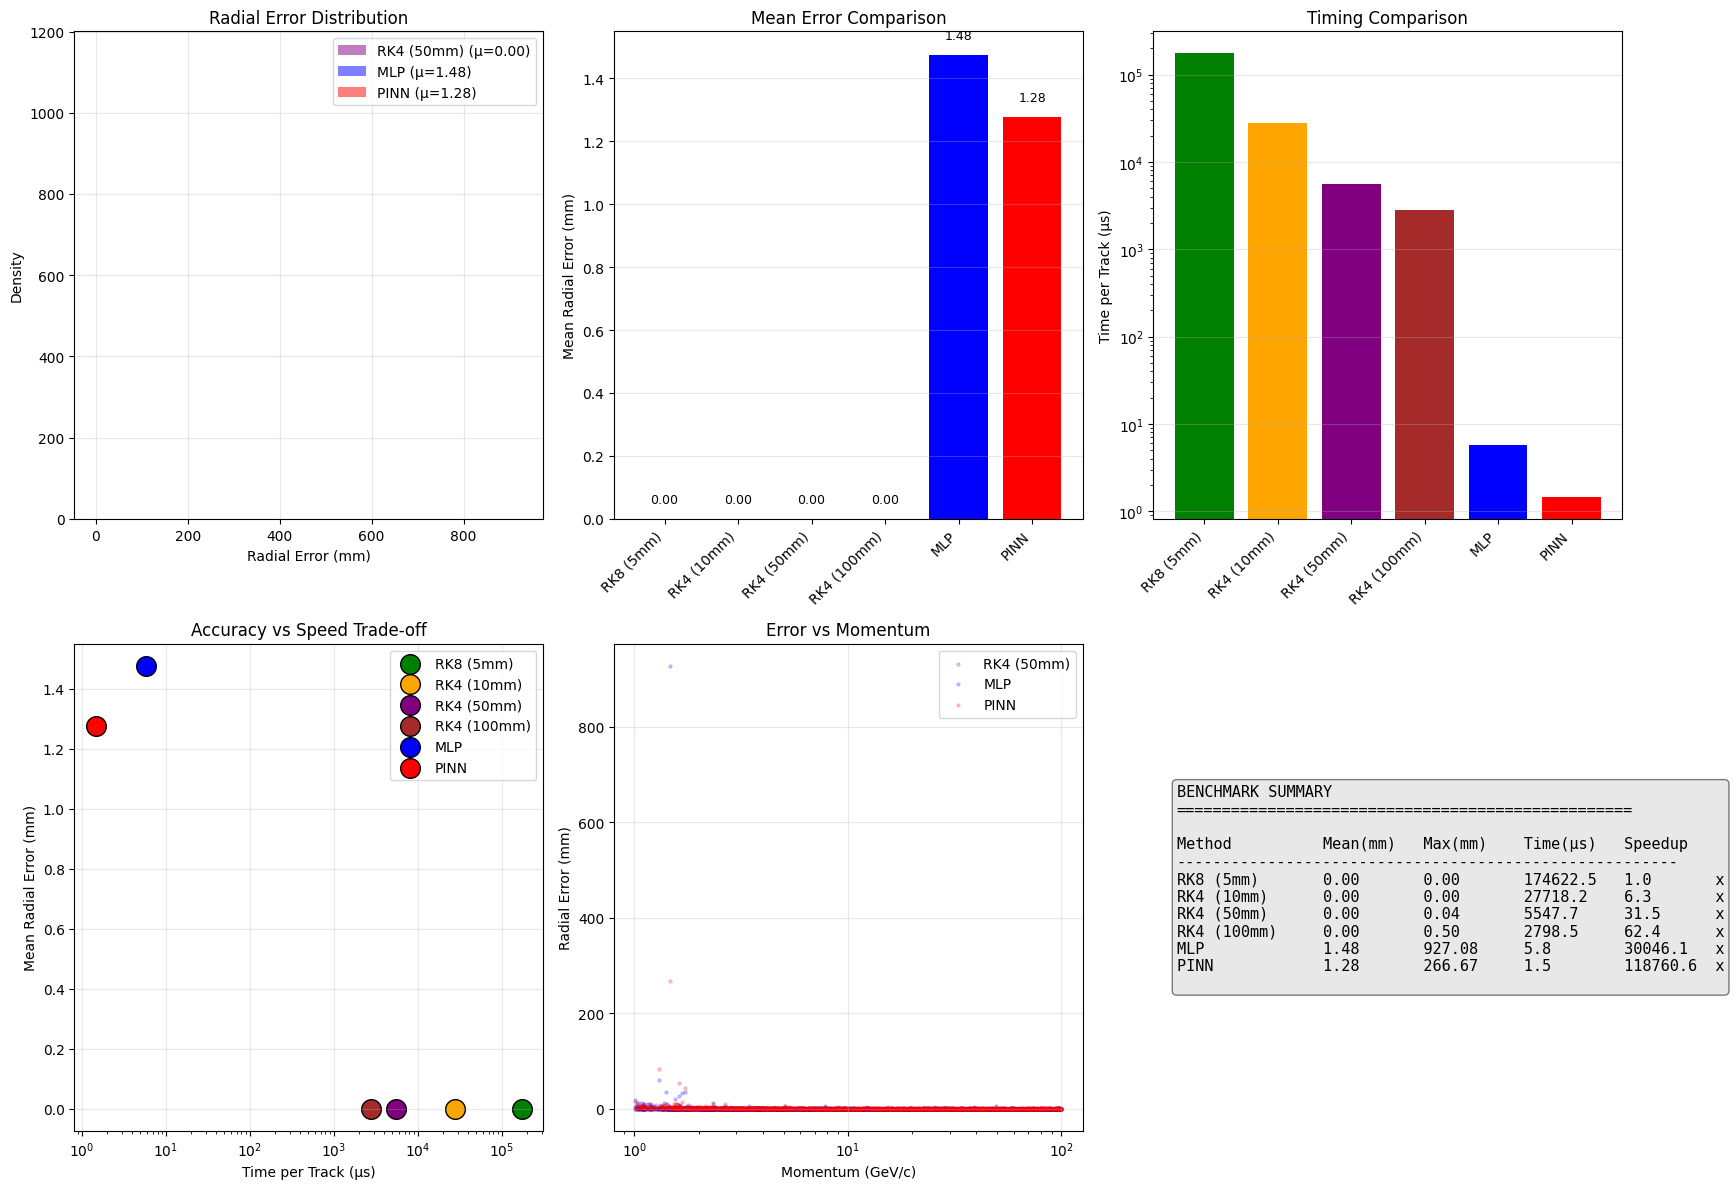

In [10]:
# Comparison Summary Plot
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

methods = list(results.keys())
colors = {'RK8 (5mm)': 'green', 'RK4 (10mm)': 'orange', 'RK4 (50mm)': 'purple',
          'RK4 (100mm)': 'brown', 'MLP': 'blue', 'PINN': 'red'}

# Error histograms
ax = axes[0, 0]
for m in ['RK4 (50mm)', 'MLP', 'PINN']:
    ax.hist(results[m]['radial'], bins=50, alpha=0.5, label=f"{m} (μ={results[m]['mean']:.2f})",
            color=colors[m], density=True)
ax.set_xlabel('Radial Error (mm)')
ax.set_ylabel('Density')
ax.set_title('Radial Error Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Mean error bar chart
ax = axes[0, 1]
means = [results[m]['mean'] for m in methods]
bars = ax.bar(range(len(methods)), means, color=[colors[m] for m in methods])
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, rotation=45, ha='right')
ax.set_ylabel('Mean Radial Error (mm)')
ax.set_title('Mean Error Comparison')
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, f'{val:.2f}', ha='center', fontsize=9)

# Timing comparison
ax = axes[0, 2]
times = [results[m]['time_us'] for m in methods]
bars = ax.bar(range(len(methods)), times, color=[colors[m] for m in methods])
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, rotation=45, ha='right')
ax.set_ylabel('Time per Track (μs)')
ax.set_title('Timing Comparison')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y')

# Accuracy vs Speed
ax = axes[1, 0]
for m in methods:
    ax.scatter(results[m]['time_us'], results[m]['mean'], s=200, label=m, color=colors[m], edgecolor='k')
ax.set_xlabel('Time per Track (μs)')
ax.set_ylabel('Mean Radial Error (mm)')
ax.set_title('Accuracy vs Speed Trade-off')
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Error vs Momentum
ax = axes[1, 1]
momenta = np.abs(1.0 / X_test[:, 4]) / 1000
for m in ['RK4 (50mm)', 'MLP', 'PINN']:
    ax.scatter(momenta, results[m]['radial'], alpha=0.2, s=5, color=colors[m], label=m)
ax.set_xlabel('Momentum (GeV/c)')
ax.set_ylabel('Radial Error (mm)')
ax.set_title('Error vs Momentum')
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Summary table
ax = axes[1, 2]
ax.axis('off')
table_text = 'BENCHMARK SUMMARY\n' + '='*50 + '\n\n'
table_text += f'{"Method":<15} {"Mean(mm)":<10} {"Max(mm)":<10} {"Time(μs)":<10} {"Speedup":<10}\n'
table_text += '-'*55 + '\n'
rk8_time = results['RK8 (5mm)']['time_us']
for m in methods:
    r = results[m]
    speedup = rk8_time / r['time_us']
    table_text += f"{m:<15} {r['mean']:<10.2f} {r['max']:<10.2f} {r['time_us']:<10.1f} {speedup:<10.1f}x\n"
ax.text(0.05, 0.5, table_text, transform=ax.transAxes, fontsize=11, family='monospace',
        va='center', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

plt.tight_layout()
plt.savefig(plots_dir / 'benchmark_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

Training history not available (models were loaded from disk). Skipping plot.


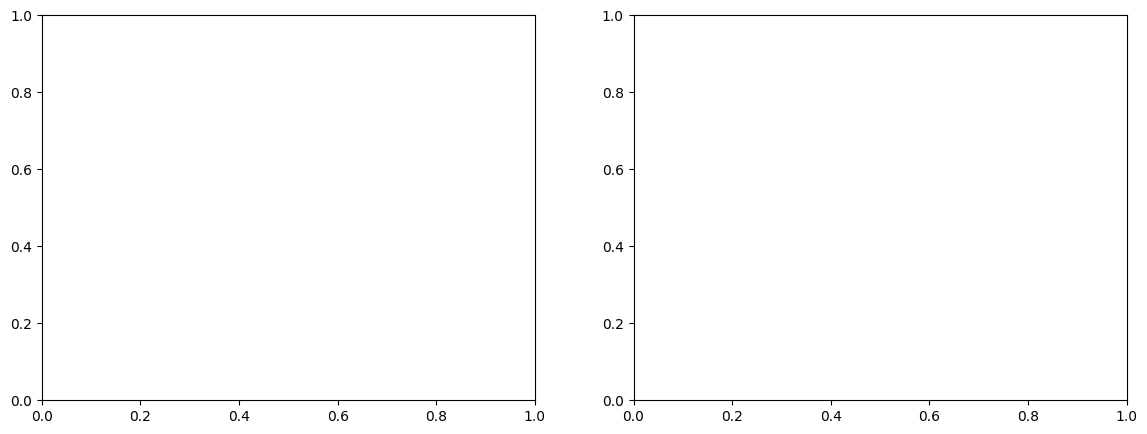

In [13]:
# Training History (skip if not available - e.g., after kernel restart with loaded models)
try:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    ax = axes[0]
    ax.semilogy(mlp_history['train'], label='Train', color='blue')
    ax.semilogy(mlp_history['val'], label='Validation', color='red')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('MLP Training History')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1]
    ax.semilogy(pinn_history['total'], label='Total', color='black')
    ax.semilogy(pinn_history['data'], label='Data', color='blue')
    ax.semilogy(pinn_history['physics'], label='Physics', color='red')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('PINN Training History')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(plots_dir / 'training_history.png', dpi=150, bbox_inches='tight')
    plt.show()
except NameError:
    print("Training history not available (models were loaded from disk). Skipping plot.")

In [12]:
# Save results
results_summary = {}
for m, r in results.items():
    results_summary[m] = {
        'mean_radial_mm': float(r['mean']),
        'std_radial_mm': float(r['std']),
        'max_radial_mm': float(r['max']),
        'p95_radial_mm': float(r['p95']),
        'time_per_track_us': float(r['time_us'])
    }

with open(models_dir / 'full_domain_results.json', 'w') as f:
    json.dump(results_summary, f, indent=4)

print('Results saved!')
print('\nFINAL SUMMARY:')
print(f'{"Method":<15} {"Mean Error":<12} {"95% Error":<12} {"Time":<12} {"Speedup"}')
print('-'*60)
rk8_time = results['RK8 (5mm)']['time_us']
for m in methods:
    r = results[m]
    print(f"{m:<15} {r['mean']:<12.2f} {r['p95']:<12.2f} {r['time_us']:<12.1f} {rk8_time/r['time_us']:.1f}x")

Results saved!

FINAL SUMMARY:
Method          Mean Error   95% Error    Time         Speedup
------------------------------------------------------------
RK8 (5mm)       0.00         0.00         174622.5     1.0x
RK4 (10mm)      0.00         0.00         27718.2      6.3x
RK4 (50mm)      0.00         0.00         5547.7       31.5x
RK4 (100mm)     0.00         0.00         2798.5       62.4x
MLP             1.48         2.41         5.8          30046.1x
PINN            1.28         2.73         1.5          118760.6x


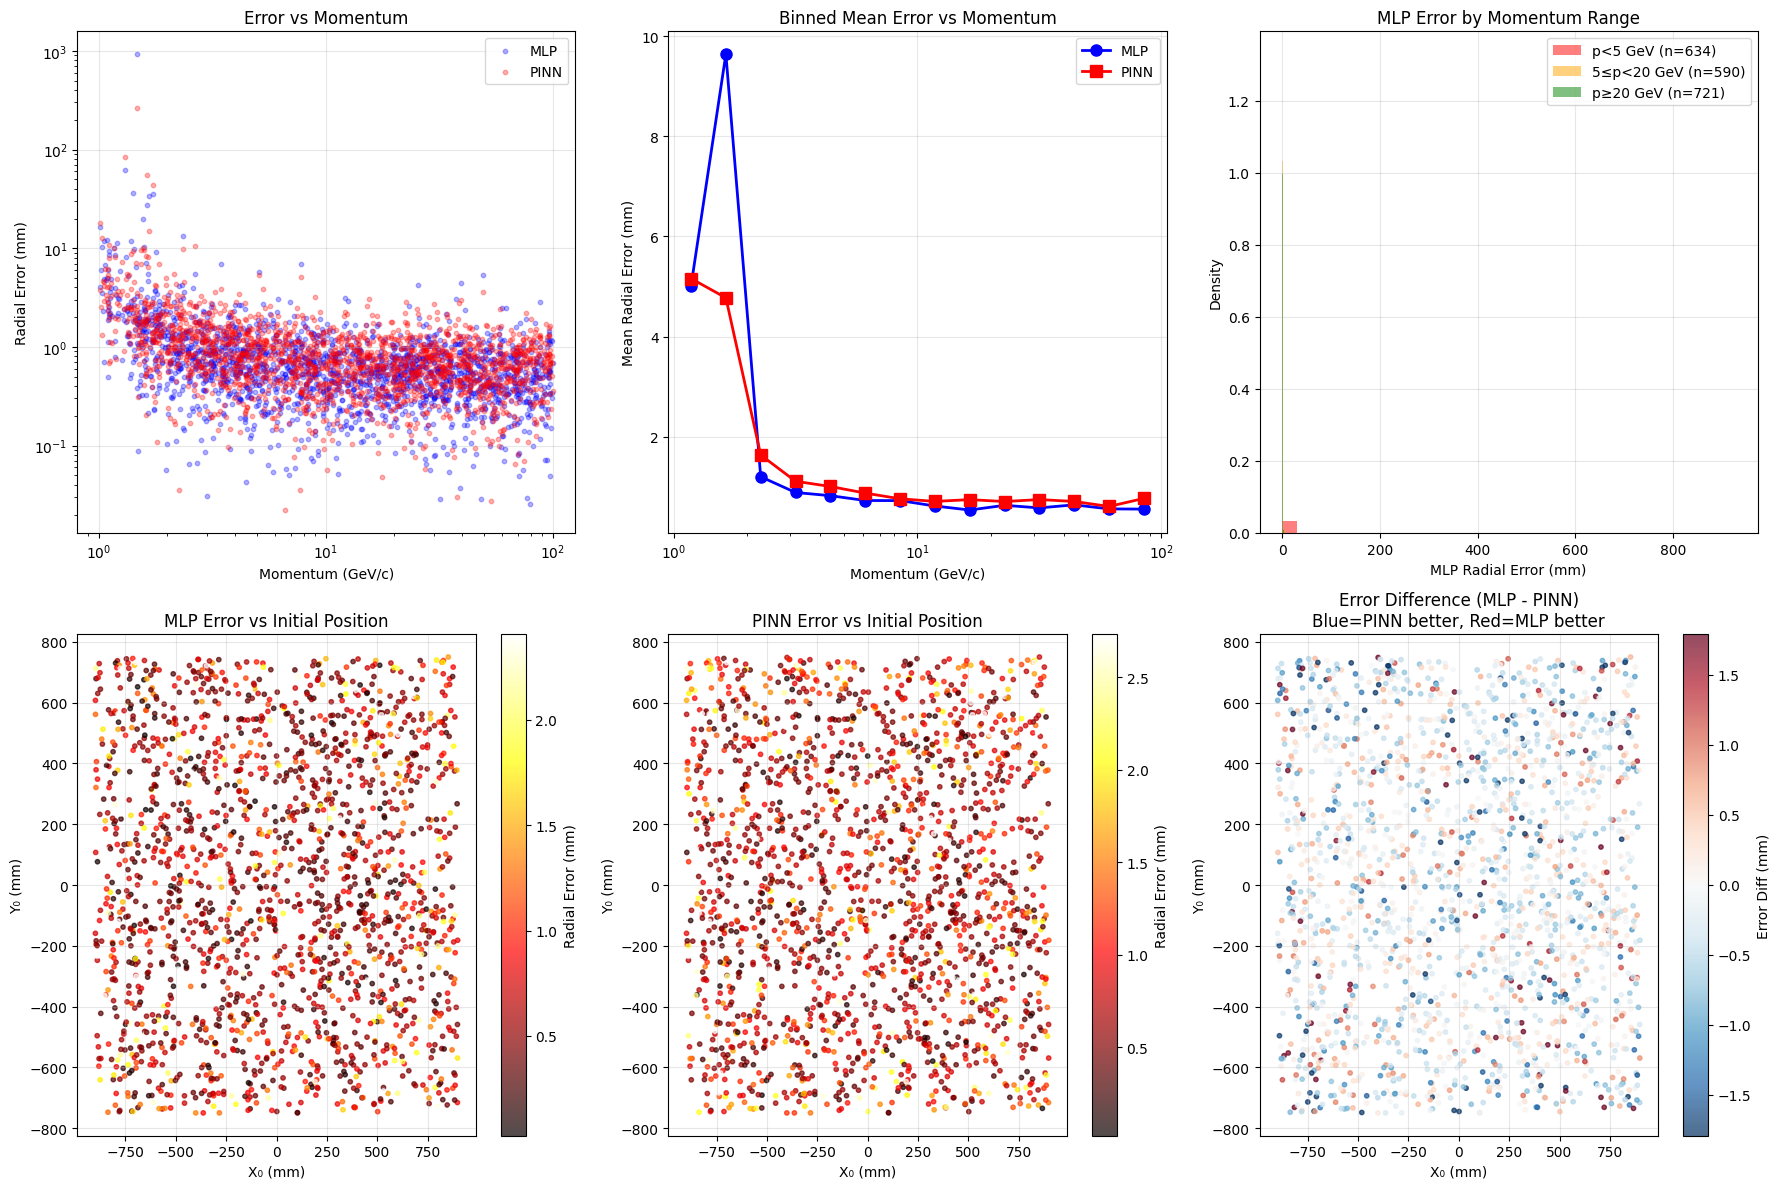


=== ERROR STATISTICS BY MOMENTUM ===
Momentum Range       MLP Mean     PINN Mean    MLP 95%      PINN 95%    
--------------------------------------------------------------------
p < 5 GeV            3.241        2.388        5.078        5.010       
5 ≤ p < 20 GeV       0.661        0.789        1.563        1.727       
p ≥ 20 GeV           0.591        0.700        1.220        1.507       


In [14]:
# Error Analysis vs Momentum and X,Y Origins
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Extract initial positions and momenta
x0 = X_test[:, 0]
y0 = X_test[:, 1]
momenta = np.abs(1.0 / X_test[:, 4]) / 1000  # GeV/c

mlp_radial = results['MLP']['radial']
pinn_radial = results['PINN']['radial']

# --- Row 1: Error vs Momentum ---
ax = axes[0, 0]
ax.scatter(momenta, mlp_radial, alpha=0.3, s=10, c='blue', label='MLP')
ax.scatter(momenta, pinn_radial, alpha=0.3, s=10, c='red', label='PINN')
ax.set_xlabel('Momentum (GeV/c)')
ax.set_ylabel('Radial Error (mm)')
ax.set_title('Error vs Momentum')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Binned mean error vs momentum
ax = axes[0, 1]
p_bins = np.logspace(0, 2, 15)  # 1 to 100 GeV
p_centers = np.sqrt(p_bins[:-1] * p_bins[1:])
mlp_binned = [mlp_radial[(momenta >= p_bins[i]) & (momenta < p_bins[i+1])].mean() 
              for i in range(len(p_bins)-1)]
pinn_binned = [pinn_radial[(momenta >= p_bins[i]) & (momenta < p_bins[i+1])].mean() 
               for i in range(len(p_bins)-1)]
ax.plot(p_centers, mlp_binned, 'b-o', lw=2, label='MLP', markersize=8)
ax.plot(p_centers, pinn_binned, 'r-s', lw=2, label='PINN', markersize=8)
ax.set_xlabel('Momentum (GeV/c)')
ax.set_ylabel('Mean Radial Error (mm)')
ax.set_title('Binned Mean Error vs Momentum')
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Error histogram by momentum range
ax = axes[0, 2]
low_p = momenta < 5
mid_p = (momenta >= 5) & (momenta < 20)
high_p = momenta >= 20
ax.hist(mlp_radial[low_p], bins=30, alpha=0.5, label=f'p<5 GeV (n={low_p.sum()})', color='red', density=True)
ax.hist(mlp_radial[mid_p], bins=30, alpha=0.5, label=f'5≤p<20 GeV (n={mid_p.sum()})', color='orange', density=True)
ax.hist(mlp_radial[high_p], bins=30, alpha=0.5, label=f'p≥20 GeV (n={high_p.sum()})', color='green', density=True)
ax.set_xlabel('MLP Radial Error (mm)')
ax.set_ylabel('Density')
ax.set_title('MLP Error by Momentum Range')
ax.legend()
ax.grid(True, alpha=0.3)

# --- Row 2: Error vs X,Y Origins ---
# MLP error vs X origin
ax = axes[1, 0]
sc = ax.scatter(x0, y0, c=mlp_radial, cmap='hot', s=10, alpha=0.7, vmax=np.percentile(mlp_radial, 95))
ax.set_xlabel('X₀ (mm)')
ax.set_ylabel('Y₀ (mm)')
ax.set_title('MLP Error vs Initial Position')
plt.colorbar(sc, ax=ax, label='Radial Error (mm)')
ax.grid(True, alpha=0.3)

# PINN error vs X origin
ax = axes[1, 1]
sc = ax.scatter(x0, y0, c=pinn_radial, cmap='hot', s=10, alpha=0.7, vmax=np.percentile(pinn_radial, 95))
ax.set_xlabel('X₀ (mm)')
ax.set_ylabel('Y₀ (mm)')
ax.set_title('PINN Error vs Initial Position')
plt.colorbar(sc, ax=ax, label='Radial Error (mm)')
ax.grid(True, alpha=0.3)

# Difference (MLP - PINN) vs position
ax = axes[1, 2]
diff = mlp_radial - pinn_radial
vmax = np.percentile(np.abs(diff), 95)
sc = ax.scatter(x0, y0, c=diff, cmap='RdBu_r', s=10, alpha=0.7, vmin=-vmax, vmax=vmax)
ax.set_xlabel('X₀ (mm)')
ax.set_ylabel('Y₀ (mm)')
ax.set_title('Error Difference (MLP - PINN)\nBlue=PINN better, Red=MLP better')
plt.colorbar(sc, ax=ax, label='Error Diff (mm)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(plots_dir / 'error_analysis_momentum_position.png', dpi=150, bbox_inches='tight')
plt.show()

# Print statistics
print("\n=== ERROR STATISTICS BY MOMENTUM ===")
print(f"{'Momentum Range':<20} {'MLP Mean':<12} {'PINN Mean':<12} {'MLP 95%':<12} {'PINN 95%':<12}")
print("-" * 68)
for name, mask in [('p < 5 GeV', low_p), ('5 ≤ p < 20 GeV', mid_p), ('p ≥ 20 GeV', high_p)]:
    print(f"{name:<20} {mlp_radial[mask].mean():<12.3f} {pinn_radial[mask].mean():<12.3f} "
          f"{np.percentile(mlp_radial[mask], 95):<12.3f} {np.percentile(pinn_radial[mask], 95):<12.3f}")

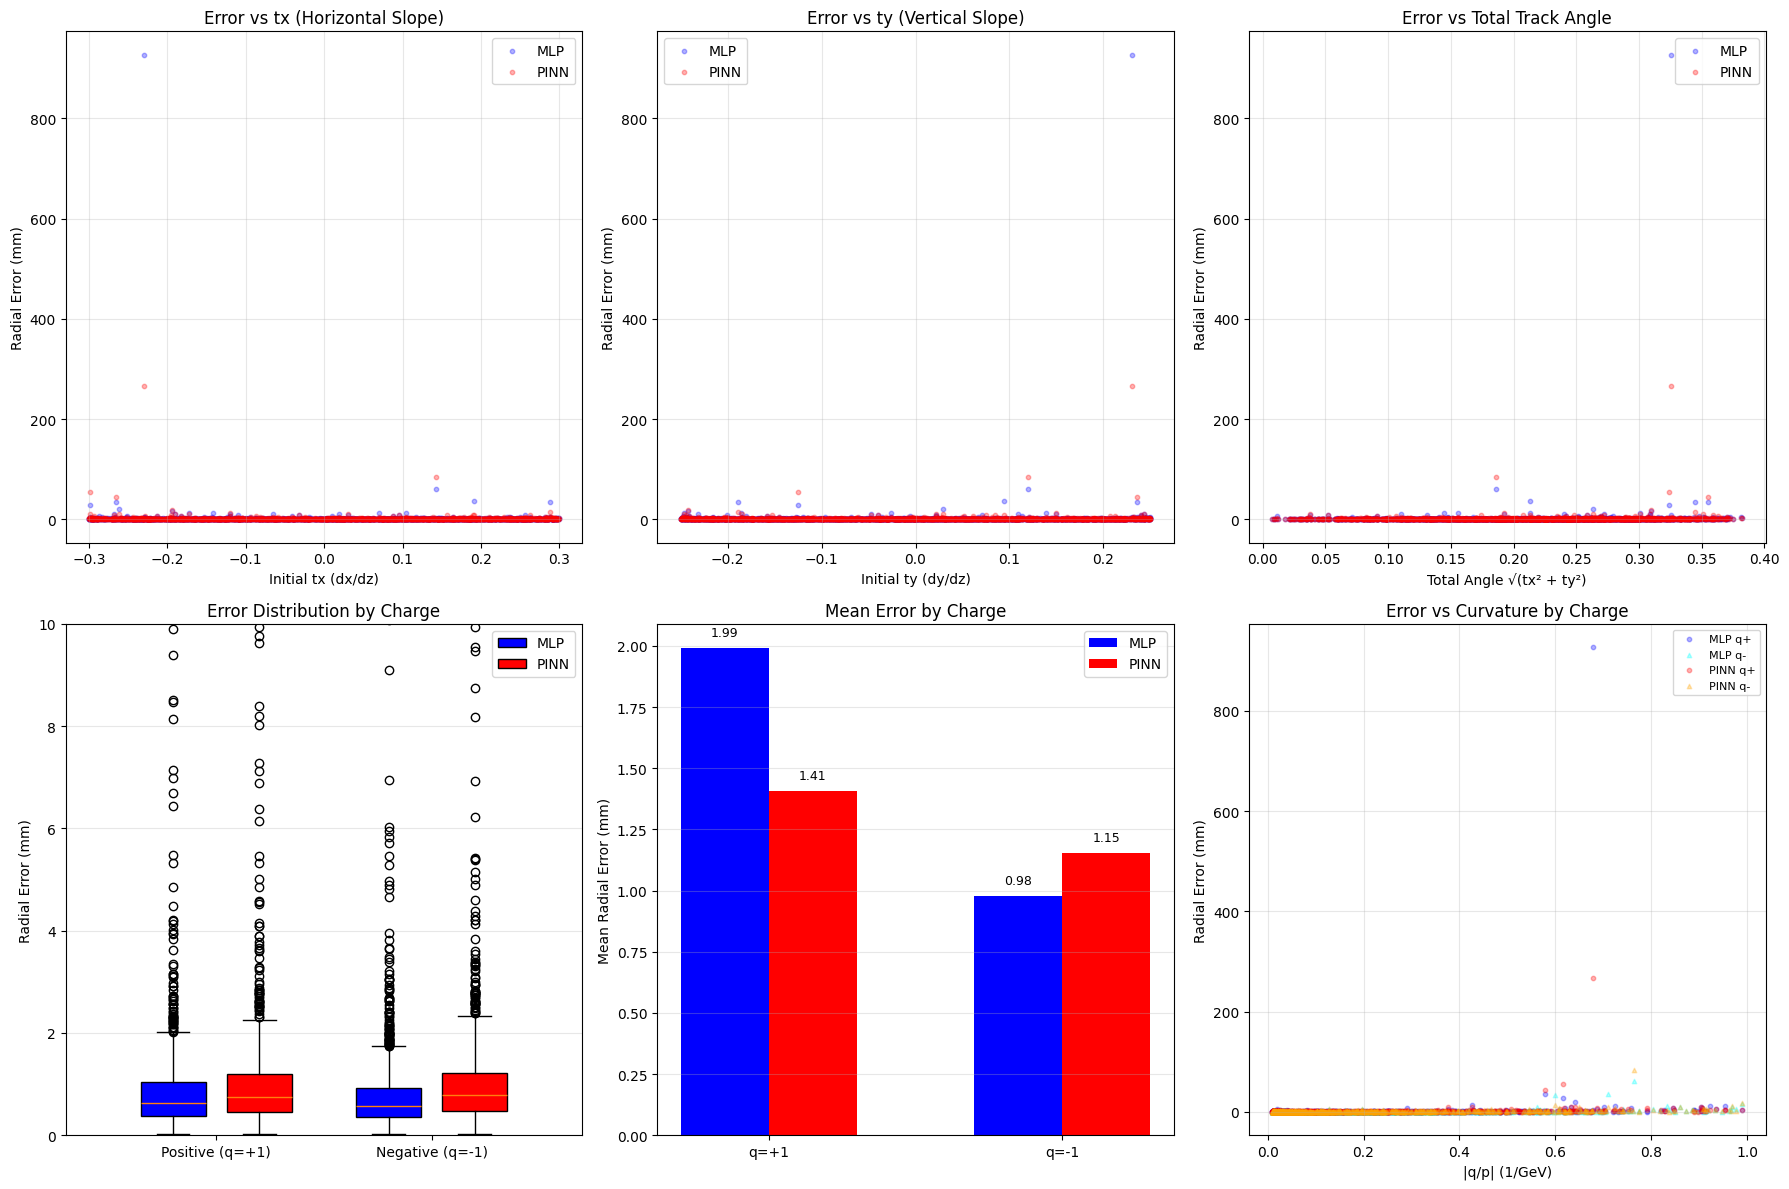


=== CHARGE ASYMMETRY STATISTICS ===
Charge       N tracks   MLP Mean     PINN Mean    MLP Std      PINN Std    
----------------------------------------------------------------------
q = +1       956        1.990        1.406        30.001       8.944       
q = -1       989        0.979        1.153        2.698        2.931       


In [16]:
# Error Analysis vs Track Angles (tx, ty) and Charge
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

tx0 = X_test[:, 2]
ty0 = X_test[:, 3]
qop = X_test[:, 4]
charges = np.sign(qop)

# --- Row 1: Error vs Angles ---
# Error vs tx
ax = axes[0, 0]
ax.scatter(tx0, mlp_radial, alpha=0.3, s=10, c='blue', label='MLP')
ax.scatter(tx0, pinn_radial, alpha=0.3, s=10, c='red', label='PINN')
ax.set_xlabel('Initial tx (dx/dz)')
ax.set_ylabel('Radial Error (mm)')
ax.set_title('Error vs tx (Horizontal Slope)')
ax.legend()
ax.grid(True, alpha=0.3)

# Error vs ty
ax = axes[0, 1]
ax.scatter(ty0, mlp_radial, alpha=0.3, s=10, c='blue', label='MLP')
ax.scatter(ty0, pinn_radial, alpha=0.3, s=10, c='red', label='PINN')
ax.set_xlabel('Initial ty (dy/dz)')
ax.set_ylabel('Radial Error (mm)')
ax.set_title('Error vs ty (Vertical Slope)')
ax.legend()
ax.grid(True, alpha=0.3)

# Error vs total angle
total_angle = np.sqrt(tx0**2 + ty0**2)
ax = axes[0, 2]
ax.scatter(total_angle, mlp_radial, alpha=0.3, s=10, c='blue', label='MLP')
ax.scatter(total_angle, pinn_radial, alpha=0.3, s=10, c='red', label='PINN')
ax.set_xlabel('Total Angle √(tx² + ty²)')
ax.set_ylabel('Radial Error (mm)')
ax.set_title('Error vs Total Track Angle')
ax.legend()
ax.grid(True, alpha=0.3)

# --- Row 2: Charge Asymmetry ---
# Separate by charge
pos_mask = charges > 0
neg_mask = charges < 0

# Box plots by charge
ax = axes[1, 0]
data_mlp = [mlp_radial[pos_mask], mlp_radial[neg_mask]]
data_pinn = [pinn_radial[pos_mask], pinn_radial[neg_mask]]
positions_mlp = [0.8, 1.8]
positions_pinn = [1.2, 2.2]
bp1 = ax.boxplot(data_mlp, positions=positions_mlp, widths=0.3, patch_artist=True)
bp2 = ax.boxplot(data_pinn, positions=positions_pinn, widths=0.3, patch_artist=True)
for patch in bp1['boxes']: patch.set_facecolor('blue')
for patch in bp2['boxes']: patch.set_facecolor('red')
ax.set_xticks([1, 2])
ax.set_xticklabels(['Positive (q=+1)', 'Negative (q=-1)'])
ax.set_ylabel('Radial Error (mm)')
ax.set_title('Error Distribution by Charge')
ax.legend([bp1['boxes'][0], bp2['boxes'][0]], ['MLP', 'PINN'])
ax.set_ylim(0, 10)
ax.grid(True, alpha=0.3, axis='y')

# Charge asymmetry statistics
ax = axes[1, 1]
charges_labels = ['q=+1', 'q=-1']
mlp_means = [mlp_radial[pos_mask].mean(), mlp_radial[neg_mask].mean()]
pinn_means = [pinn_radial[pos_mask].mean(), pinn_radial[neg_mask].mean()]
x = np.arange(2)
ax.bar(x - 0.15, mlp_means, 0.3, label='MLP', color='blue')
ax.bar(x + 0.15, pinn_means, 0.3, label='PINN', color='red')
ax.set_xticks(x)
ax.set_xticklabels(charges_labels)
ax.set_ylabel('Mean Radial Error (mm)')
ax.set_title('Mean Error by Charge')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
for i, (m, p) in enumerate(zip(mlp_means, pinn_means)):
    ax.text(i-0.15, m+0.05, f'{m:.2f}', ha='center', fontsize=9)
    ax.text(i+0.15, p+0.05, f'{p:.2f}', ha='center', fontsize=9)

# Error vs 1/p (curvature) colored by charge
ax = axes[1, 2]
curvature = np.abs(qop) * 1000  # 1/GeV
ax.scatter(curvature[pos_mask], mlp_radial[pos_mask], alpha=0.3, s=10, c='blue', marker='o', label='MLP q+')
ax.scatter(curvature[neg_mask], mlp_radial[neg_mask], alpha=0.3, s=10, c='cyan', marker='^', label='MLP q-')
ax.scatter(curvature[pos_mask], pinn_radial[pos_mask], alpha=0.3, s=10, c='red', marker='o', label='PINN q+')
ax.scatter(curvature[neg_mask], pinn_radial[neg_mask], alpha=0.3, s=10, c='orange', marker='^', label='PINN q-')
ax.set_xlabel('|q/p| (1/GeV)')
ax.set_ylabel('Radial Error (mm)')
ax.set_title('Error vs Curvature by Charge')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(plots_dir / 'error_vs_angles_charge.png', dpi=150, bbox_inches='tight')
plt.show()

# Print statistics
print("\n=== CHARGE ASYMMETRY STATISTICS ===")
print(f"{'Charge':<12} {'N tracks':<10} {'MLP Mean':<12} {'PINN Mean':<12} {'MLP Std':<12} {'PINN Std':<12}")
print("-" * 70)
print(f"{'q = +1':<12} {pos_mask.sum():<10} {mlp_radial[pos_mask].mean():<12.3f} {pinn_radial[pos_mask].mean():<12.3f} "
      f"{mlp_radial[pos_mask].std():<12.3f} {pinn_radial[pos_mask].std():<12.3f}")
print(f"{'q = -1':<12} {neg_mask.sum():<10} {mlp_radial[neg_mask].mean():<12.3f} {pinn_radial[neg_mask].mean():<12.3f} "
      f"{mlp_radial[neg_mask].std():<12.3f} {pinn_radial[neg_mask].std():<12.3f}")

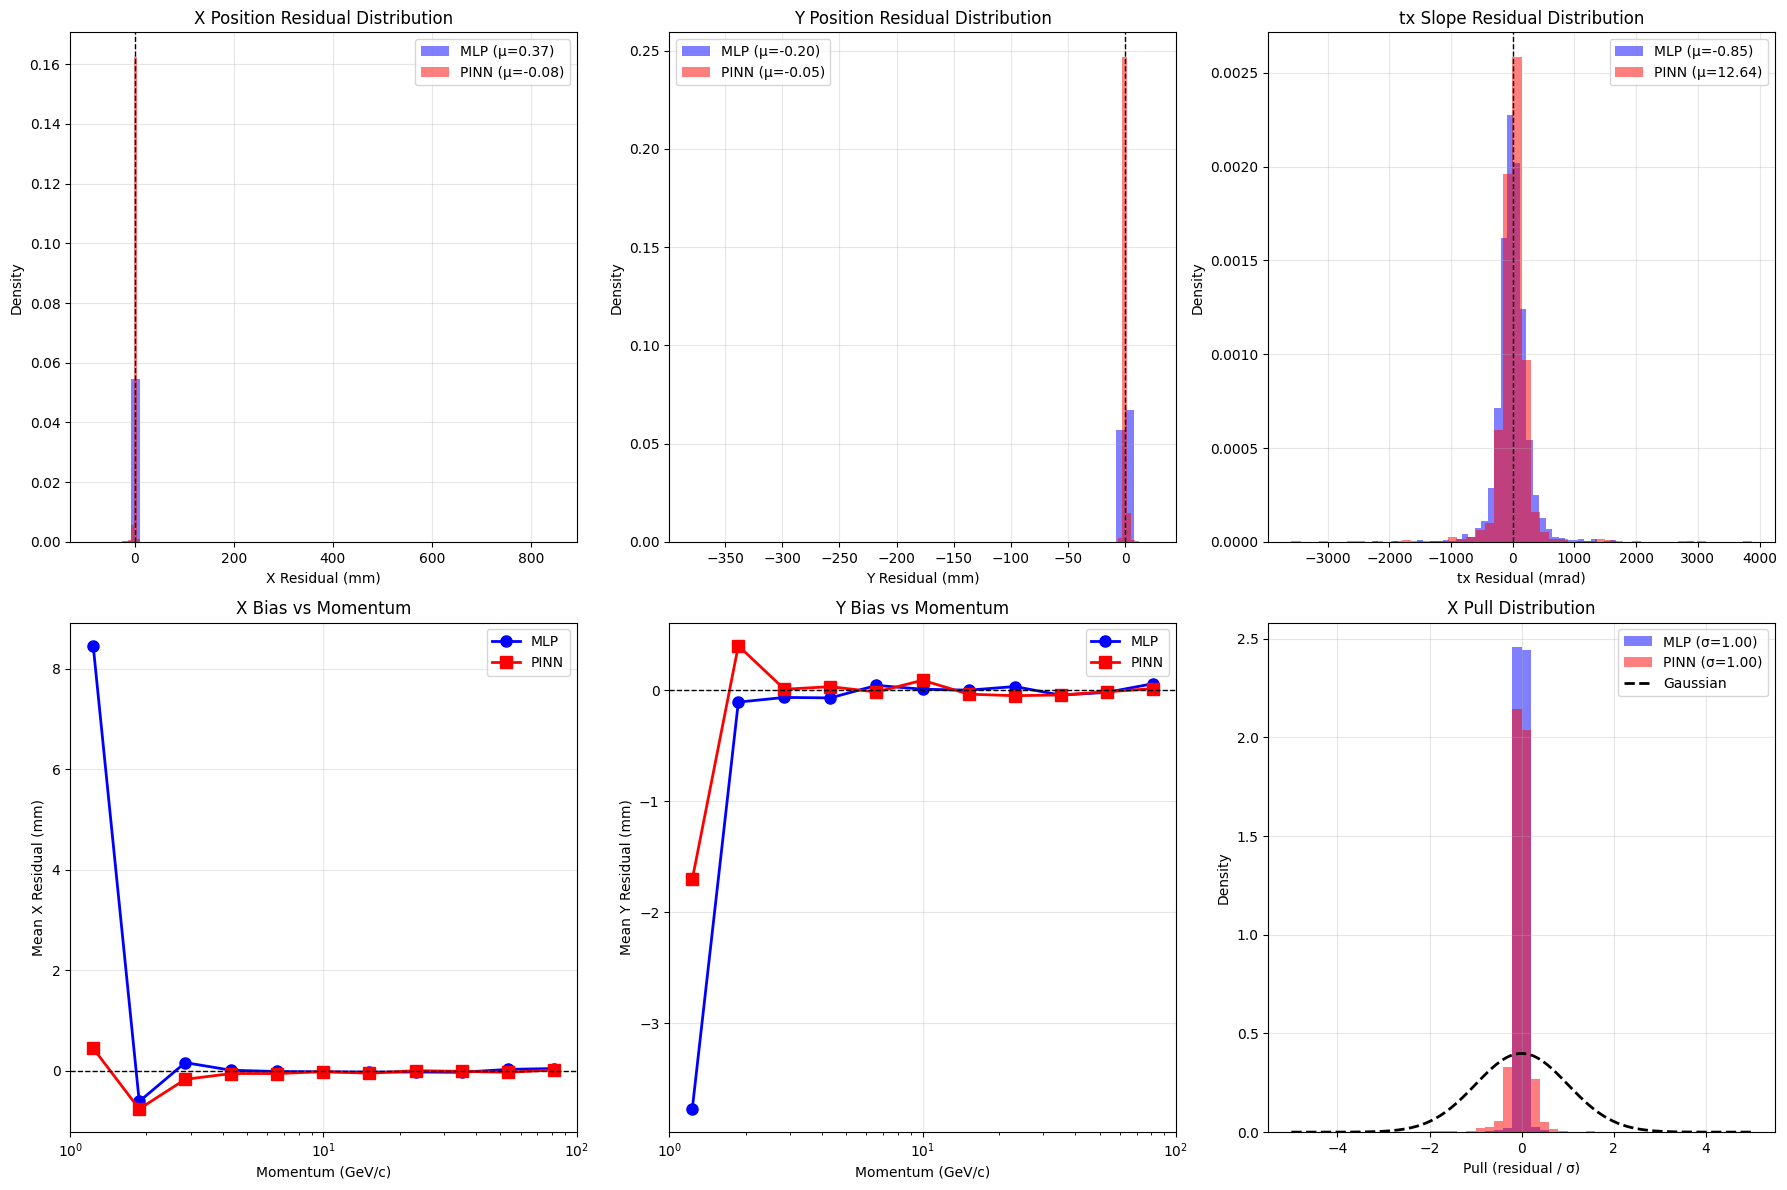


=== SYSTEMATIC BIAS SUMMARY ===
Variable        MLP Mean     MLP RMS      PINN Mean    PINN RMS    
---------------------------------------------------------------
X (mm)          0.371        19.316       -0.081       5.481       
Y (mm)          -0.199       8.675        -0.046       3.909       
tx (mrad)       -0.849       259.900      12.643       313.339     
ty (mrad)       3.700        87.228       -1.106       72.807      


In [18]:
# Systematic Bias Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Get actual predictions
mlp_model.eval()
pinn_model.eval()
X_t = torch.FloatTensor(X_test)
X_pinn_t = torch.FloatTensor(np.hstack([X_test[:, :5], np.full((len(X_test), 1), 7000.0)]))

with torch.no_grad():
    mlp_pred = mlp_model(X_t).numpy()
    pinn_pred = pinn_model(X_pinn_t).numpy()

# Residuals (prediction - truth)
mlp_res_x = mlp_pred[:, 0] - Y_test[:, 0]
mlp_res_y = mlp_pred[:, 1] - Y_test[:, 1]
mlp_res_tx = mlp_pred[:, 2] - Y_test[:, 2]
mlp_res_ty = mlp_pred[:, 3] - Y_test[:, 3]

pinn_res_x = pinn_pred[:, 0] - Y_test[:, 0]
pinn_res_y = pinn_pred[:, 1] - Y_test[:, 1]
pinn_res_tx = pinn_pred[:, 2] - Y_test[:, 2]
pinn_res_ty = pinn_pred[:, 3] - Y_test[:, 3]

# --- Row 1: Residual distributions ---
ax = axes[0, 0]
ax.hist(mlp_res_x, bins=50, alpha=0.5, label=f'MLP (μ={mlp_res_x.mean():.2f})', color='blue', density=True)
ax.hist(pinn_res_x, bins=50, alpha=0.5, label=f'PINN (μ={pinn_res_x.mean():.2f})', color='red', density=True)
ax.axvline(0, color='k', linestyle='--', lw=1)
ax.set_xlabel('X Residual (mm)')
ax.set_ylabel('Density')
ax.set_title('X Position Residual Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.hist(mlp_res_y, bins=50, alpha=0.5, label=f'MLP (μ={mlp_res_y.mean():.2f})', color='blue', density=True)
ax.hist(pinn_res_y, bins=50, alpha=0.5, label=f'PINN (μ={pinn_res_y.mean():.2f})', color='red', density=True)
ax.axvline(0, color='k', linestyle='--', lw=1)
ax.set_xlabel('Y Residual (mm)')
ax.set_ylabel('Density')
ax.set_title('Y Position Residual Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 2]
ax.hist(mlp_res_tx * 1000, bins=50, alpha=0.5, label=f'MLP (μ={mlp_res_tx.mean()*1000:.2f})', color='blue', density=True)
ax.hist(pinn_res_tx * 1000, bins=50, alpha=0.5, label=f'PINN (μ={pinn_res_tx.mean()*1000:.2f})', color='red', density=True)
ax.axvline(0, color='k', linestyle='--', lw=1)
ax.set_xlabel('tx Residual (mrad)')
ax.set_ylabel('Density')
ax.set_title('tx Slope Residual Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# --- Row 2: Bias vs momentum ---
ax = axes[1, 0]
p_bins = np.logspace(0, 2, 12)
p_centers = np.sqrt(p_bins[:-1] * p_bins[1:])
mlp_bias_x = [mlp_res_x[(momenta >= p_bins[i]) & (momenta < p_bins[i+1])].mean() for i in range(len(p_bins)-1)]
pinn_bias_x = [pinn_res_x[(momenta >= p_bins[i]) & (momenta < p_bins[i+1])].mean() for i in range(len(p_bins)-1)]
ax.plot(p_centers, mlp_bias_x, 'b-o', lw=2, label='MLP', markersize=8)
ax.plot(p_centers, pinn_bias_x, 'r-s', lw=2, label='PINN', markersize=8)
ax.axhline(0, color='k', linestyle='--', lw=1)
ax.set_xlabel('Momentum (GeV/c)')
ax.set_ylabel('Mean X Residual (mm)')
ax.set_title('X Bias vs Momentum')
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
mlp_bias_y = [mlp_res_y[(momenta >= p_bins[i]) & (momenta < p_bins[i+1])].mean() for i in range(len(p_bins)-1)]
pinn_bias_y = [pinn_res_y[(momenta >= p_bins[i]) & (momenta < p_bins[i+1])].mean() for i in range(len(p_bins)-1)]
ax.plot(p_centers, mlp_bias_y, 'b-o', lw=2, label='MLP', markersize=8)
ax.plot(p_centers, pinn_bias_y, 'r-s', lw=2, label='PINN', markersize=8)
ax.axhline(0, color='k', linestyle='--', lw=1)
ax.set_xlabel('Momentum (GeV/c)')
ax.set_ylabel('Mean Y Residual (mm)')
ax.set_title('Y Bias vs Momentum')
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Pull distributions (residual / expected error)
ax = axes[1, 2]
# Simple pull using RMS as error estimate
mlp_rms_x = np.std(mlp_res_x)
pinn_rms_x = np.std(pinn_res_x)
mlp_pull_x = mlp_res_x / mlp_rms_x
pinn_pull_x = pinn_res_x / pinn_rms_x
ax.hist(mlp_pull_x, bins=50, alpha=0.5, label=f'MLP (σ={mlp_pull_x.std():.2f})', color='blue', density=True, range=(-5, 5))
ax.hist(pinn_pull_x, bins=50, alpha=0.5, label=f'PINN (σ={pinn_pull_x.std():.2f})', color='red', density=True, range=(-5, 5))
x_gauss = np.linspace(-5, 5, 100)
ax.plot(x_gauss, np.exp(-x_gauss**2/2)/np.sqrt(2*np.pi), 'k--', lw=2, label='Gaussian')
ax.set_xlabel('Pull (residual / σ)')
ax.set_ylabel('Density')
ax.set_title('X Pull Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(plots_dir / 'systematic_bias_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Print bias summary
print("\n=== SYSTEMATIC BIAS SUMMARY ===")
print(f"{'Variable':<15} {'MLP Mean':<12} {'MLP RMS':<12} {'PINN Mean':<12} {'PINN RMS':<12}")
print("-" * 63)
print(f"{'X (mm)':<15} {mlp_res_x.mean():<12.3f} {mlp_res_x.std():<12.3f} {pinn_res_x.mean():<12.3f} {pinn_res_x.std():<12.3f}")
print(f"{'Y (mm)':<15} {mlp_res_y.mean():<12.3f} {mlp_res_y.std():<12.3f} {pinn_res_y.mean():<12.3f} {pinn_res_y.std():<12.3f}")
print(f"{'tx (mrad)':<15} {mlp_res_tx.mean()*1000:<12.3f} {mlp_res_tx.std()*1000:<12.3f} {pinn_res_tx.mean()*1000:<12.3f} {pinn_res_tx.std()*1000:<12.3f}")
print(f"{'ty (mrad)':<15} {mlp_res_ty.mean()*1000:<12.3f} {mlp_res_ty.std()*1000:<12.3f} {pinn_res_ty.mean()*1000:<12.3f} {pinn_res_ty.std()*1000:<12.3f}")

## 8. Weighted Loss Training Experiment

Train a model with momentum-weighted loss to improve low-p performance.

In [7]:
# Weighted Loss Training - upweight low momentum tracks
# Use minimum momentum of 2 GeV to avoid numerical instability

def generate_data_with_momentum(n_samples, min_p=2.0, max_p=100.0, seed=42):
    """Generate training data with momentum info returned."""
    np.random.seed(seed)
    field = LHCbMagneticField(polarity=1)
    integrator = RKIntegrator(field, step_size=10.0, use_rk8=True)
    z_in, z_out = 3000.0, 7000.0
    dz = z_out - z_in
    
    X_list, Y_list, P_list = [], [], []
    n_attempts = 0
    
    while len(X_list) < n_samples and n_attempts < n_samples * 3:
        n_attempts += 1
        x0 = np.random.uniform(-900, 900)
        y0 = np.random.uniform(-750, 750)
        tx0 = np.random.uniform(-0.3, 0.3)
        ty0 = np.random.uniform(-0.25, 0.25)
        p_gev = np.exp(np.random.uniform(np.log(min_p), np.log(max_p)))
        charge = np.random.choice([-1, 1])
        qop = charge / (p_gev * 1000.0)
        
        state_in = np.array([x0, y0, tx0, ty0, qop])
        state_out = integrator.propagate(state_in, z_in, z_out)
        
        if (np.all(np.isfinite(state_out)) and np.abs(state_out[2]) < 5 and
            np.abs(state_out[0]) < 5000 and np.abs(state_out[1]) < 5000):
            X_list.append([x0, y0, tx0, ty0, qop, dz])
            Y_list.append(state_out[:4])
            P_list.append(p_gev)
        
        if len(X_list) % 5000 == 0 and len(X_list) > 0:
            print(f"  Generated {len(X_list)}/{n_samples}")
    
    return np.array(X_list), np.array(Y_list), np.array(P_list)

def train_weighted_mlp(X, Y, P, epochs=800, lr=1e-3, batch_size=256, weight_power=2.0):
    """Train with momentum-weighted loss."""
    n_train = int(0.85 * len(X))
    X_t = torch.FloatTensor(X[:n_train])
    Y_t = torch.FloatTensor(Y[:n_train])
    P_t = torch.FloatTensor(P[:n_train])
    X_val = torch.FloatTensor(X[n_train:])
    Y_val = torch.FloatTensor(Y[n_train:])
    
    model = TrackMLP()
    model.input_mean = X_t.mean(dim=0)
    model.input_std = X_t.std(dim=0) + 1e-8
    model.output_mean = Y_t.mean(dim=0)
    model.output_std = Y_t.std(dim=0) + 1e-8
    
    # Weights: higher for lower momentum
    weights = (P_t.max() / P_t) ** weight_power
    weights = weights / weights.mean()
    
    dataset = TensorDataset(X_t, Y_t, weights.unsqueeze(1))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    history = {'train': [], 'val': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for bx, by, bw in loader:
            optimizer.zero_grad()
            pred = model(bx)
            loss = (bw * (pred - by)**2).mean()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(loader)
        scheduler.step()
        
        model.eval()
        with torch.no_grad():
            val_loss = ((model(X_val) - Y_val)**2).mean().item()
        
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        
        if (epoch + 1) % 200 == 0:
            print(f"  Epoch {epoch+1}: Train={train_loss:.4f}, Val={val_loss:.4f}")
    
    return model, history

print("Generating training data (min_p=2 GeV for stability)...")
X_w, Y_w, P_w = generate_data_with_momentum(15000, min_p=2.0, max_p=100.0, seed=42)
print(f"Training samples: {len(X_w)}")
print(f"Momentum range: {P_w.min():.1f} - {P_w.max():.1f} GeV/c")

Generating training data (min_p=2 GeV for stability)...
  Generated 5000/15000
  Generated 10000/15000
  Generated 15000/15000
Training samples: 15000
Momentum range: 2.0 - 99.9 GeV/c


In [8]:
# Load or save training data
data_dir = base_dir / 'ml_models' / 'data'
data_dir.mkdir(exist_ok=True)

LOAD_FROM_DISK = True  # Set to True to load saved data, False to regenerate

if LOAD_FROM_DISK and (data_dir / 'X_weighted_train.npy').exists():
    print("Loading saved training data...")
    X_w = np.load(data_dir / 'X_weighted_train.npy')
    Y_w = np.load(data_dir / 'Y_weighted_train.npy')
    P_w = np.load(data_dir / 'P_weighted_train.npy')
    print(f"  Loaded X_w: {X_w.shape}, Y_w: {Y_w.shape}, P_w: {P_w.shape}")
else:
    # Save for future use
    np.save(data_dir / 'X_weighted_train.npy', X_w)
    np.save(data_dir / 'Y_weighted_train.npy', Y_w)
    np.save(data_dir / 'P_weighted_train.npy', P_w)
    print(f"Saved training data to {data_dir}")

Loading saved training data...
  Loaded X_w: (15000, 6), Y_w: (15000, 4), P_w: (15000,)


In [9]:
# Train weighted model (500 epochs for faster completion)
print("Training WEIGHTED loss model (power=2)...")
model_weighted, hist_weighted = train_weighted_mlp(X_w, Y_w, P_w, epochs=500, weight_power=2.0)
print("Training complete!")

# Generate test data for weighted experiment
print("\nGenerating test data...")
X_test_w, Y_test_w, P_test_w = generate_data_with_momentum(2000, min_p=2.0, max_p=100.0, seed=123)
print(f"Test samples: {len(X_test_w)}")

Training WEIGHTED loss model (power=2)...
  Epoch 200: Train=216.1758, Val=222.2525
  Epoch 400: Train=1.6627, Val=7.2444
Training complete!

Generating test data...
Test samples: 2000



=== WEIGHTED VS ORIGINAL MLP COMPARISON ===

Momentum Bin    Original MLP    Weighted MLP    Improvement 
---------------------------------------------------------
2-5 GeV       1.006           2.721           -170.4%
5-10 GeV       0.675           1.677           -148.4%
10-20 GeV       0.598           1.812           -202.9%
20-50 GeV       0.588           1.887           -220.8%
50-100 GeV       0.568           1.803           -217.3%

OVERALL         0.694           2.001           -188.6%


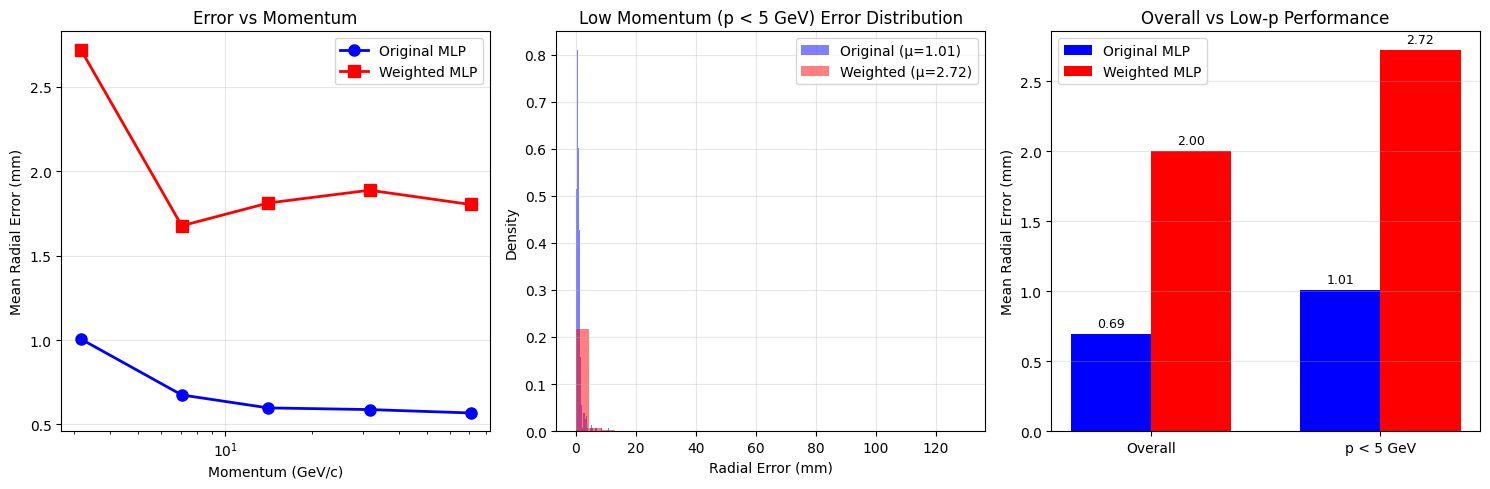


Weighted model saved to /data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/ml_models/models/mlp_weighted.bin


In [10]:
# Compare weighted vs original MLP
print("\n=== WEIGHTED VS ORIGINAL MLP COMPARISON ===\n")

# Evaluate original MLP (already loaded)
mlp_model.eval()
model_weighted.eval()

X_t_w = torch.FloatTensor(X_test_w)
with torch.no_grad():
    pred_orig = mlp_model(X_t_w).numpy()
    pred_weighted = model_weighted(X_t_w).numpy()

err_orig = np.sqrt((pred_orig[:, 0] - Y_test_w[:, 0])**2 + (pred_orig[:, 1] - Y_test_w[:, 1])**2)
err_weighted = np.sqrt((pred_weighted[:, 0] - Y_test_w[:, 0])**2 + (pred_weighted[:, 1] - Y_test_w[:, 1])**2)

# Stats by momentum bin
p_bins = [(2, 5), (5, 10), (10, 20), (20, 50), (50, 100)]
print(f"{'Momentum Bin':<15} {'Original MLP':<15} {'Weighted MLP':<15} {'Improvement':<12}")
print("-" * 57)

for p_low, p_high in p_bins:
    mask = (P_test_w >= p_low) & (P_test_w < p_high)
    if mask.sum() > 0:
        m_orig = err_orig[mask].mean()
        m_weighted = err_weighted[mask].mean()
        imp = (m_orig - m_weighted) / m_orig * 100
        print(f"{p_low}-{p_high} GeV       {m_orig:<15.3f} {m_weighted:<15.3f} {imp:>+.1f}%")

print(f"\n{'OVERALL':<15} {err_orig.mean():<15.3f} {err_weighted.mean():<15.3f} {(err_orig.mean()-err_weighted.mean())/err_orig.mean()*100:>+.1f}%")

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Error by momentum
ax = axes[0]
p_centers = np.sqrt(np.array([2, 5]) * np.array([5, 10]))
p_centers = np.array([3.16, 7.07, 14.1, 31.6, 70.7])
orig_means = [err_orig[(P_test_w >= p_bins[i][0]) & (P_test_w < p_bins[i][1])].mean() for i in range(len(p_bins))]
weighted_means = [err_weighted[(P_test_w >= p_bins[i][0]) & (P_test_w < p_bins[i][1])].mean() for i in range(len(p_bins))]
ax.plot(p_centers, orig_means, 'b-o', lw=2, label='Original MLP', markersize=8)
ax.plot(p_centers, weighted_means, 'r-s', lw=2, label='Weighted MLP', markersize=8)
ax.set_xlabel('Momentum (GeV/c)')
ax.set_ylabel('Mean Radial Error (mm)')
ax.set_title('Error vs Momentum')
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Error histograms at low p
ax = axes[1]
low_p_mask = P_test_w < 5
ax.hist(err_orig[low_p_mask], bins=30, alpha=0.5, label=f'Original (μ={err_orig[low_p_mask].mean():.2f})', color='blue', density=True)
ax.hist(err_weighted[low_p_mask], bins=30, alpha=0.5, label=f'Weighted (μ={err_weighted[low_p_mask].mean():.2f})', color='red', density=True)
ax.set_xlabel('Radial Error (mm)')
ax.set_ylabel('Density')
ax.set_title('Low Momentum (p < 5 GeV) Error Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Overall comparison
ax = axes[2]
x = np.arange(2)
width = 0.35
bars1 = ax.bar(x - width/2, [err_orig.mean(), err_orig[low_p_mask].mean()], width, label='Original MLP', color='blue')
bars2 = ax.bar(x + width/2, [err_weighted.mean(), err_weighted[low_p_mask].mean()], width, label='Weighted MLP', color='red')
ax.set_ylabel('Mean Radial Error (mm)')
ax.set_title('Overall vs Low-p Performance')
ax.set_xticks(x)
ax.set_xticklabels(['Overall', 'p < 5 GeV'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
for bar in bars1 + bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, f'{bar.get_height():.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(plots_dir / 'weighted_loss_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Save weighted model
model_weighted.save_binary(str(models_dir / 'mlp_weighted.bin'))
print(f"\nWeighted model saved to {models_dir / 'mlp_weighted.bin'}")